# **Sistem Rekomendasi Barang Jualan (CNN)**


### Mengimpor library

In [5]:
import numpy as np 
import pandas as pd
import cv2
import zipfile
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import tensorflow as tf
import datetime, os
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

from tensorflow.keras import layers
from tensorflow.keras import Model
from keras import models

%matplotlib inline

### Penggunaan Kaggle

In [6]:
! pip install -q kaggle

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadwafiyulloh","key":"a28f7a0ed6b974623c4efd744a538064"}'}

### Pengaksesan Dataset

In [8]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download muhammadwafiyulloh/fashiondatasetfiltered

 25% 6.00M/24.0M [00:00<00:00, 60.7MB/s]
100% 24.0M/24.0M [00:00<00:00, 134MB/s] 


In [10]:
local_zip = '/content/fashiondatasetfiltered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [11]:
!ls '/content/'

FASHION-DATASET-FILTERED  fashiondatasetfiltered.zip  kaggle.json  sample_data


### Menampilkan Direktori

In [12]:
DATASET_PATH = "/content/"
print(os.listdir(DATASET_PATH))

['.config', 'kaggle.json', 'fashiondatasetfiltered.zip', 'FASHION-DATASET-FILTERED', 'sample_data']


### Persiapan Dataset

In [40]:
# Sebagai dasar direktori
base_dir = DATASET_PATH + 'FASHION-DATASET-FILTERED/'
# Membuat link folder train
train_dir = os.path.join( base_dir, 'train')
# Membuat link folder validation
validation_dir = os.path.join( base_dir, 'validation')
#ukuran gambar yang diinputkan
input_size = 150
#Jumlah class yang ada di dataset
total_class = len(os.listdir(base_dir + 'train/'))
#Mengambil class yang ada di dataset
fashion_class = os.listdir(base_dir + 'train/')
fashion_class.sort()

#Persiapan data untuk training
train_datagen = ImageDataGenerator(rescale = 1./255.)
#Persiapan data untuk validation
test_datagen = ImageDataGenerator( rescale = 1./255. )
#membuat train generator dengan parameter yang dimasukkan
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 128,
                                                    class_mode='sparse',
                                                    target_size = (input_size, input_size))     
#membuat validation generator dengan parameter yang dimasukkan
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size = 128,
                                                          class_mode  = 'sparse', 
                                                          target_size = (input_size, input_size))

Found 4616 images belonging to 7 classes.
Found 490 images belonging to 7 classes.


>#### Persiapan Tautan Gambar Diletakkan di List

In [39]:
import shutil

dir = DATASET_PATH + 'FASHION-DATASET-FILTERED/'
traindata = os.listdir(dir + 'train/')
testdata = os.listdir(dir+ 'validation/')
total_linkImages = []

# Membuat direktori untuk menggabungkan seluruh gambar
if os.path.isdir(dir + 'filtered_images/') == True:
  if len(os.listdir(dir + 'filtered_images/')) <=  0:
    os.rmdir(dir + 'filtered_images/')
else:
  os.makedirs(dir + 'filtered_images')

# iterasi berdasarkan jumlah class
for i in range(0, total_class) :
  #Memasukkan link gambar ke list dari folder train
  trainlist = os.listdir(dir + 'train/'+ traindata[i])
  for trainim in trainlist:
    total_linkImages.append(dir + 'train/'+ traindata[i]+'/' +trainim)

  #Memasukkan link gambar ke list dari folder validation
  testlist = os.listdir(dir + 'validation/'+ testdata[i])
  for testim in testlist:
    total_linkImages.append(dir + 'validation/'+ testdata[i]+'/' +testim)

#menyalin gambar dari sumber kepada folder 'filtered_images'
for i in range(0, len(total_linkImages)):
  shutil.copy(total_linkImages[i], dir + 'filtered_images/')

#mencetak jumlahnya dan isinya
print(len(total_linkImages))
print(total_linkImages)

5106
['/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.10366.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.25930.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.41153.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.34148.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.57083.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.32591.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.39330.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.28456.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.37930.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.57087.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.5586.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.10652.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.39314.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.47657.jpg', '/content/FASHION-DATASET-FILTERED/train/Rok/Skirts.30922.jpg', '/content/FASHION-DATASET-FILTERED/

### Persiapan Pre-Trained Model

In [15]:
# mengunduh weight pre-trained model
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-06-05 09:06:03--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.128, 209.85.200.128, 108.177.112.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   171MB/s    in 0.5s    

2022-06-05 09:06:04 (171 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
# menyimpan weight file 
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Inisialisasi model
# menyetel ukuran masukkan gambar
pre_trained_model = InceptionV3(input_shape = (input_size, input_size, 3), 
                                include_top = False, 
                                weights = None)

# mengisi weight pre-trained model
pre_trained_model.load_weights(local_weights_file)

# freeze weight pada layer
for layer in pre_trained_model.layers:
  layer.trainable = False

In [17]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [18]:
# Pemilihan layer terakhir sebagai model dasar
base_model = pre_trained_model.get_layer('mixed3')
print('output dari based model: ', base_model.output_shape)
base_model_output = base_model.output

output dari based model:  (None, 7, 7, 768)


### Perancangan Model CNN

In [19]:
#Fungsi perancangan model CNN 
def create_model():
    model = layers.Flatten()(base_model_output)
    model = layers.Dense(512, activation='relu')(model)
    model = layers.Dropout(0.3)(model)                  
    model = layers.Dense(total_class, activation= "softmax")(model)           

    model = Model(pre_trained_model.input, model) 

    return model


In [20]:
# Mengeksekusi fungsinya
model=create_model()
# Keterangan mengenai model
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [21]:
#meng-compile model yang telah dibuat 
model.compile(
    loss ='sparse_categorical_crossentropy', 
    optimizer = 'adam',
    metrics =['accuracy'])

###Proses Training pada Model

In [22]:
#Callback untuk Menghentikan Training
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.96) and (logs.get('val_accuracy') > 0.86):
      print("\nTraining model dihentikan!")
      self.model.stop_training = True
callbacks = myCallback()

In [23]:
history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    epochs=150, 
    verbose = 2,
    callbacks=callbacks)

Epoch 1/150
37/37 - 144s - loss: 7.4111 - accuracy: 0.7192 - val_loss: 1.3853 - val_accuracy: 0.8490 - 144s/epoch - 4s/step
Epoch 2/150
37/37 - 136s - loss: 0.4690 - accuracy: 0.8956 - val_loss: 0.4343 - val_accuracy: 0.8796 - 136s/epoch - 4s/step
Epoch 3/150
37/37 - 136s - loss: 0.2194 - accuracy: 0.9283 - val_loss: 0.3795 - val_accuracy: 0.8857 - 136s/epoch - 4s/step
Epoch 4/150
37/37 - 128s - loss: 0.1432 - accuracy: 0.9539 - val_loss: 0.4572 - val_accuracy: 0.8755 - 128s/epoch - 3s/step
Epoch 5/150
37/37 - 136s - loss: 0.1302 - accuracy: 0.9562 - val_loss: 0.3844 - val_accuracy: 0.9020 - 136s/epoch - 4s/step
Epoch 6/150

Training model dihentikan!
37/37 - 136s - loss: 0.0772 - accuracy: 0.9725 - val_loss: 0.3703 - val_accuracy: 0.8939 - 136s/epoch - 4s/step


### Evaluasi Model

<Figure size 432x288 with 0 Axes>

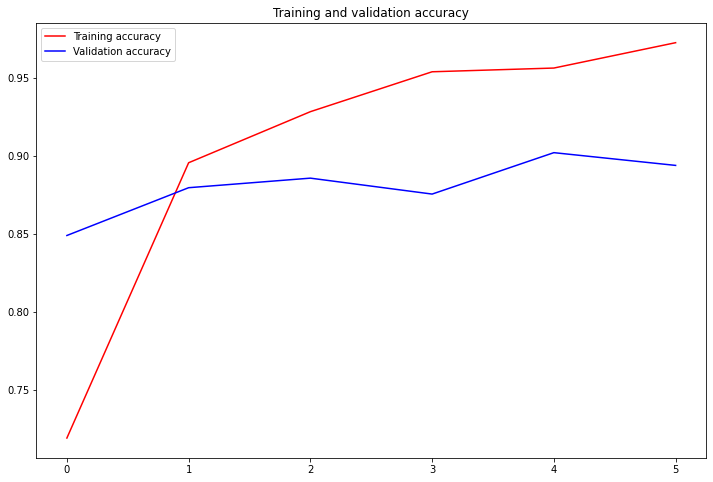

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(12, 8))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

In [26]:
# Menyimpan model
model.save('Recommendation_System_CNN.h5')

In [27]:
# Mengisi model
model = models.load_model('Recommendation_System_CNN.h5')

In [62]:
# Mengunduh model
from google.colab import files
files.download('Recommendation_System_CNN.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Prediksi gambar yang diberikan

In [29]:
def prediction(img):
    # Mengatur ulang ukuran gambar
    resized_img = cv2.resize(img, dsize=(input_size, input_size), interpolation = cv2.INTER_AREA)    
    # Mengubah gambar menjadi numpy dengan ukuran (150,150,3)
    x_data = np.array(img).reshape(-1,input_size, input_size,3)
    # Normalisasi
    x_data=x_data/255
    # Prediksi gambar
    res=model.predict(x_data)

    return x_data,fashion_class[np.argmax(res)]

> #### Prediksi Gambar dari Dataset

Prediction: 
Kategori Baju


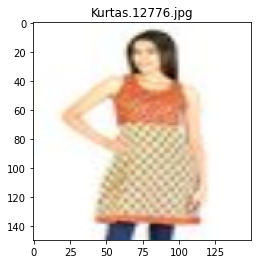

In [76]:
#Memilih gambar dengan index pada folder
pointed_image = 1000

#menyimpan gambar-gambar menjadi list
imageList = os.listdir(dir + 'filtered_images/')

#tautan lokasi gambar
Image_path= dir + 'filtered_images/'

#Mendapatkan gambar sesuai dengan index-nya
image_point = imageList[pointed_image]

# membuka/membaca gambar
image = cv2.imread( Image_path + image_point ,cv2.IMREAD_COLOR)

# mengubah ukuran gambar
realIm = cv2.resize(image, dsize=(input_size, input_size))

# konversi BGR ke RGB
realIm=cv2.cvtColor(realIm,cv2.COLOR_BGR2RGB)

#menampilkan gambar
plt.title(image_point)
plt.imshow(realIm)

#menampilkan hasil prediksi
print('Prediction: ')
numpyIm,class_image=prediction(realIm)
print('Kategori',class_image)


> #### Prediksi Gambar dari Sumber Berbeda

In [77]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  # menyimpan tautan
  path = fn
  
  #mengatur ulang citranya
  img = cv2.imread(path,cv2.IMREAD_COLOR)
  img = cv2.resize(img, dsize=(input_size, input_size))
  realIm = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

  #menampilkan hasil prediksi
  numpyIm,class_image=prediction(realIm)
  plt.imshow(realIm)
  print(class_image)

In [78]:
#menghapus gambar di folder content
for i in os.listdir('/content/'):
  if i.endswith('.JPG') or i.endswith('.png') or i.endswith('.jpg'):
    os.remove('/content/'+ i)

### Sistem Merekomendasikan Barang

> #### Mengumpulkan gambar dengan class gambar yang sama


In [79]:
## Mengumpulkan gambar dengan class gambar yang sama

# Penyimpanan nama file
X_nameimage=[]
# Penyimpanan gambar
X_images=[]
# Penyimpanan numpy array gambar
X_numpy=[]

# iterasi tautan gambar
for image in total_linkImages:
  #String dijadikan list 
  tempim = image.split('/')
  
  #Memasukkan gambar dengan class yang sama 
  if tempim[4] == class_image:
    
    #pengolahan citra digital
    im = cv2.imread(image)
    resizedIm = cv2.resize(im, dsize=(input_size,input_size))
    
    #menyimpan gambar
    X_images.append(resizedIm)
    #menyimpan nama file
    X_nameimage.append(tempim[5])
# Mengubah gambar-gambar menjadi numpy array dengan ukuran (150,150,3)
X_numpy = np.array(X_images).reshape(-1, input_size,input_size,3)
# Menormalisasikan Numpy array
X_numpy = X_numpy/255

> #### Mengumpulkan Gambar Berdasarkan Jarak Vektor

In [82]:
# Penyimpanan Jarak Vektor pada gambar
distList=[]
for i in range (0, len(X_numpy)):
    #Menghitung jarak vektor antara hasil prediksi dengan gambar pada class yang sama
    Vec_dist = math.sqrt(np.sum((numpyIm-X_numpy[i])**2))

    #menyimpan jarak vektornya
    distList.append(Vec_dist)

#Mengurutkan Jarak vektor dari yang terkecil 
distancesSorted=distList.copy()
print(distList)
distancesSorted.sort()

# Memilih jarak vektor yang lebih baik
best_distances=distancesSorted[0:10]
# Menghapus duplikasi nilai
best_distances = list(dict.fromkeys(best_distances))
print(best_distances)

# Menymimpan index jarak vektor
distIndex=[]
for i in range (0, len(best_distances)):
  distIndex.append(distList.index(best_distances[i]))

print(distIndex)

[73.37377232503239, 54.782530463488854, 61.41371306352625, 82.22656334851683, 56.28172625724946, 92.27824896801437, 60.03626726536873, 63.01764800447077, 81.70702107743686, 72.08203718391186, 46.98705475032414, 56.09818821042368, 57.30952242878137, 57.21533362790973, 72.80355359718587, 60.28726312065433, 61.6189458424588, 80.07805515457706, 84.78047487273405, 60.49508061761039, 65.8394169148295, 76.88810866033897, 58.13933256876721, 69.82758774843286, 63.86555539338477, 64.81996324840672, 53.43304088059204, 58.18435667586202, 73.7129874671889, 60.35625492565388, 66.11429898717196, 57.53691104201566, 59.525622473626775, 56.172277569964656, 74.40545262437674, 60.856449922062446, 60.10805546190124, 55.95902933615379, 64.95021830111546, 72.52666799298946, 62.456659821166525, 63.87501191585844, 60.96915929579846, 61.526968296500314, 74.71949379370412, 52.97369865265889, 54.19837173434608, 48.85466854851239, 81.68899913560583, 72.55263340231112, 59.47267414222323, 54.27931832943689, 61.57633

Tops.11013.jpg
Kurtas.12069.jpg
Kurtas.12061.jpg
Innerwear Vests.17889.jpg
Kurtis.12111.jpg
Sweatshirts.12536.jpg
Kurtas.12072.jpg
Kurtis.40194.jpg
Shirts.11100.jpg
Tshirts.10646.jpg


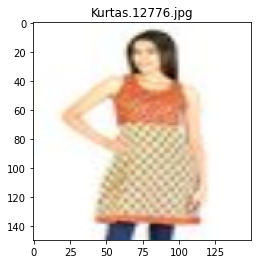

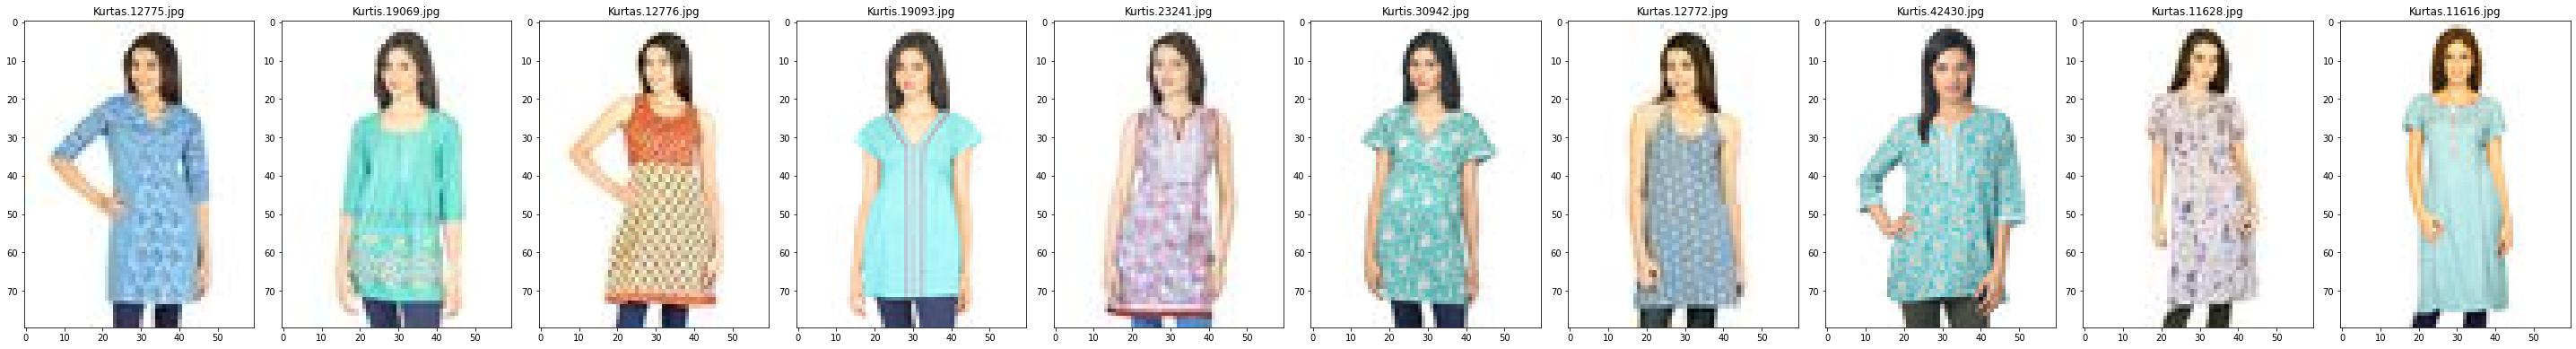

In [83]:
## Menampilkan gambar yang direkomendasikan
plt.title(image_point)
plt.imshow(realIm)

fig=plt.figure()
fig.set_figheight(40)
fig.set_figwidth(40)
axis=[]
for i in range(0,len(distIndex)):
    print(X_nameimage[i])
    image_src = cv2.imread(dir + 'filtered_images/'+str(X_nameimage[distIndex[i]]))
    image = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB) 

    axis.append(fig.add_subplot(1,len(distIndex),i+1))
    subplot_title=str(X_nameimage[distIndex[i]])
    axis[-1].set_title(subplot_title)  
    plt.imshow(image)

fig.tight_layout()
plt.show()
    